
<img src="https://raw.githubusercontent.com/hectormelo/Machine-Learning-Techniques/main/Banner.png" ><br>
# Machine Learning Techniques - MISIS4219

Primer semestre - 2024

- **Integrante 1: Julian Mora**
- **Integrante 2: Miguel Zapata**

Uno de los fenómenos más grandes que se presentan hoy en día son las opiniones de los usuarios sobre diferentes temas a través de Internet. Esta opinión es muy valiosa ya que permite saber en tiempo real y de primera mano los sentimientos que tienen las personas sobre un producto o servicio.

Es por ello, que una cadena hotelera en Andalucía ha decidido extraer la información de las opiniones de sus usuarios que han publicado en internet. Con el fin de poder entender cuáles son las ideas principales de los usuarios acerca de sus servicios, qué aspectos resaltan ellos sobre su servicios y, lo más importante, saber en qué pueden mejorar. Además, con este banco de datos esperan poder entrenar un modelo que les permita automáticamente determinar el sentimiento del usuario basado en las nuevas opiniones que puedan dejar.

Para poder tomar decisiones en este estudio, se debe presentar:

* Un análisis de las palabras más importantes en cada una de las categorías que le den relevancia a la cadena hotelera.

* Un proceso de limpieza y transformación de datos idóneo para el entrenamiento de los algoritmos.

* Una tabla comparativa, mostrando el rendimiento los dos mejores modelos entrenados con Naïve Bayes y KNN.

* A partir de la tabla comparativa, ¿cuál modelo ofrece el mejor rendimiento sobre el conjunto test? ¿Qué interpretación puedes darles a los valores obtenidos sobre las métricas de rendimiento?


**Datos**: Big_AHR.csv

## Diccionario de Datos

Se dan a disposición 13330 reviews de los usuarios los caules están compuestos de la siguiente forma:

* **Review’s title**: Título del review dado por el usuario.
* **5-scale rating**: Calificación del usuario. Escala de 1 a 5.
* **Text**: Review del usuario.
* **City_Region**: Región donde pertenece el hotel.
* **Hotel’s name**: Nombre del hotel evaluado.
* **Binary sentiment label** Clasificación sentimental. Donde 0 es Negativo, 1 es Positivo y 3 es Neutral.

### Librerías e importación de datos

In [ ]:
# Importar librerias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesamiento de textos
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import string

nltk.download('punkt')
nltk.download('stopwords')

In [2]:
# Importar datos
reviews = pd.read_csv('Big_AHR.csv', index_col=0)

### Exploración Inicial

In [3]:
# Tipos de datos y NAs
print(reviews.info())
print(reviews.isna().sum())
reviews.head()

<class 'pandas.core.frame.DataFrame'>
Index: 18172 entries, 0 to 18171
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        18172 non-null  object
 1   rating       18172 non-null  int64 
 2   review_text  18172 non-null  object
 3   location     16356 non-null  object
 4   hotel        16356 non-null  object
 5   label        18172 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 993.8+ KB
None
title             0
rating            0
review_text       0
location       1816
hotel          1816
label             0
dtype: int64


,title,rating,review_text,location,hotel,label
0,Excelente y personal amable,5,Un hotel muy bueno. El personal fue muy amabl...,Seville_Province_of_Seville_Andalucia,H10_Casa_de_la_Plata,1
1,Céntrico,4,"Muy buen hotel al nivel de lo esperado, habita...",Seville_Province_of_Seville_Andalucia,H10_Casa_de_la_Plata,1
2,Hotel excepcional,5,Magnífico hotel. La verdad es que todo perfect...,Seville_Province_of_Seville_Andalucia,H10_Casa_de_la_Plata,1
3,WOW!!,5,"Hotel hermoso, buen diseño, original, limpio. ...",Seville_Province_of_Seville_Andalucia,H10_Casa_de_la_Plata,1
4,Magnifico,5,Magnífica ubicación en pleno centro de Sevilla...,Seville_Province_of_Seville_Andalucia,H10_Casa_de_la_Plata,1


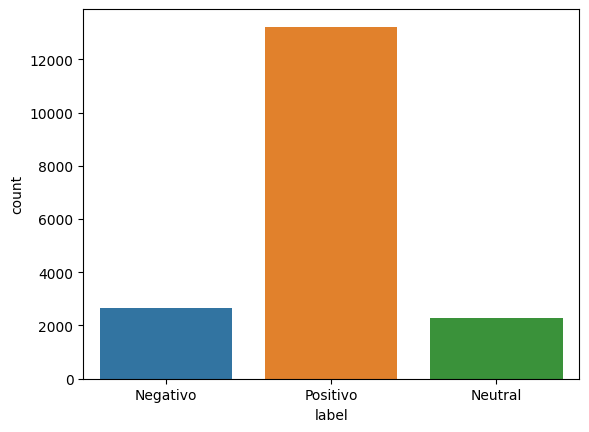

In [4]:
# Visualización de la variable objetivo
fig, ax = plt.subplots()
sns.countplot(data=reviews, x='label')
ax.set_xticks(ticks=[0, 1, 2], labels=['Negativo', 'Positivo', 'Neutral'])
plt.show()

Se ve un imbalance en la variable objetivo. No vemos necesario técnicas de remuestreo (undersampling o oversampling) porque los modelos que vamos a usar (Naive Bayes, KNN y GradientBoosting) son relativamente robustos a imbalances.

### Limpieza y transformación
Vamos a unir las variables 'title' y 'review_text'. También vamos a quitar 'rating', 'location' y 'hotel'. Haciendo un énfasis exclusivo en las reseñas de los usuarios. (Para el objetivo de negocio no vemos relevante incluir la ubicación y el hotel. El rating lo removemos porque puede quitar poder explicativo al análisis de lenguaje)

In [5]:
# Seleccionar carácteristicas
reviews['text'] = reviews['title'] + ' ' + reviews['review_text']
reviews.drop(columns=['rating', 'location', 'hotel'])
reviews = reviews[['text', 'label']]
reviews.head()

,text,label
0,Excelente y personal amable Un hotel muy bueno...,1
1,Céntrico Muy buen hotel al nivel de lo esperad...,1
2,Hotel excepcional Magnífico hotel. La verdad e...,1
3,"WOW!! Hotel hermoso, buen diseño, original, li...",1
4,Magnifico Magnífica ubicación en pleno centro ...,1


In [6]:
# Preprocesamiento de textos
stop_words = set(stopwords.words('spanish'))
punctuation = set(string.punctuation)
stemmer = SnowballStemmer('spanish')

def preprocess_text(text):
    tokens = word_tokenize(text.lower()) # Pasar texto a mínuscula y tokenizar
    tokens = [word for word in tokens if word not in stop_words and word not in punctuation] # Filtrar stopwords y puntuación
    tokens_stemmed = [stemmer.stem(word) for word in tokens] # Stemming
    return ' '.join(tokens_stemmed)

class TextProcessing(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return [preprocess_text(text) for text in X]

pipeline = Pipeline([('preprocessing', TextProcessing())])
    
pipeline.transform(reviews['text'][0:5])

['excelent personal amabl hotel buen personal amabl profesional gust desayun habit comod limpi volv proxim vez sevill segur recom ubic cerc centr',
 'centric buen hotel nivel esper habit junior suit grand deseabl estanci confort trat personal agrad ubic buen hac turism sup centric igual desayun estupend',
 'hotel excepcional magnif hotel verd perfect habit ampli actual equip amabl eficient desayun magnif pati precios part cerc mejor 4 estrell urban',
 'wow hotel hermos buen diseñ original limpi servici excelent buen ubic just enfrent carrefour express rod tiend pizz esquin estan buenisim sup recomend',
 'magnif magnif ubic plen centr sevill recorr ciud camin habit perfect gran cam diseñ tipic estil actualiz desayun complet buen lug unic felic hotel repet']